In [3]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
from tqdm import tqdm
import pandas as pd
from difflib import SequenceMatcher
import time
from joblib import Parallel, delayed
import threading
import json

<h1 align="center">PART 1</h1>

In [4]:
def scrape_names():
    program_url = "https://ic2s2-2023.org/program" # Program URL
    chairs_url = "https://ic2s2-2023.org/organization" # Chairs URL
    keynotes_url = "https://ic2s2-2023.org/keynotes" # Keynotes URL

    # Scrape program page
    program_response = requests.get(program_url)
    program_soup = BeautifulSoup(program_response.text, 'html.parser')

    # Extract and split names by comma and remove extra spaces
    program_names = []
    for tag in program_soup.find_all('i'):
        names = tag.get_text(strip=True).split(',')  # Split by comma
        clean_names = [name.strip('" ').strip() for name in names]  # Remove extra spaces/quotes
        program_names.extend(clean_names)  # Add to the final list

    # Scrape chairs page
    chairs_response = requests.get(chairs_url)
    chairs_soup = BeautifulSoup(chairs_response.text, 'html.parser')
    chairs_names = [a.get_text(strip=True) for a in chairs_soup.select("h3 a")] # names are stored in <a> within <h3> tags

    # Scape keynotes page
    keynotes_response = requests.get(keynotes_url)
    keynotes_soup = BeautifulSoup(keynotes_response.text, 'html.parser')
    keynotes_names = [a.get_text(strip=True) for a in keynotes_soup.select("h3 a")] # names are stored in <a> within <h3> tags again

    # Returning names in dict 
    return {
        "program_names": program_names,
        "chairs_names": chairs_names,
        "keynotes_names": keynotes_names
    }

In [5]:
names = scrape_names() # Getting all names

Elements_to_remove = ["SAGE", "DIREC", "EPJ", "Esteban Moro (EPJkeynote)"] # Found some errors in keynotes_names - we just remove them manually
for element in Elements_to_remove:
    names["keynotes_names"].remove(element)

names["keynotes_names"].append("Esteban Moro") # Add back Esteban Moro without the (EPJkeynote) part

all_names = names["program_names"] + names["chairs_names"] + names["keynotes_names"] # combining all names into a list

all_names = list(set(all_names)) # This removes 578 duplicates

# remove all names that contain the string Chair
all_names = [name for name in all_names if "Chair" not in name]


In [6]:
# Final list with names
len(all_names)

1498

In [7]:

# < ---- > 
# Method to find highly similar names
# Should work with defualt python libs

from difflib import SequenceMatcher

def are_almost_similar(s1, s2, threshold=0.8):
    return SequenceMatcher(None, s1, s2).ratio() >= threshold

def find_similar_names(all_names, threshold=0.8):
    similar_pairs = []
    for i in range(len(all_names)):
        for j in range(i + 1, len(all_names)):
            if are_almost_similar(all_names[i], all_names[j], threshold):
                similar_pairs.append((all_names[i], all_names[j]))
    return similar_pairs

# < ---- >

# Find and print similar names
similar_names = find_similar_names(all_names, threshold=0.8)
print(f"similar names: {similar_names}")

# In most cases the similar names are just the same name, but including the middle name or initial.
# Lets keep the longest entry and remove the shorter one
# Identify names to remove
names_to_remove = {name2 if len(name1) > len(name2) else name1 for name1, name2 in similar_names}

# Remove names
all_names = [name for name in all_names if name not in names_to_remove]


similar names: [('Ziwen Chen', 'Zexun Chen'), ('Shintaro Sakai', 'Shintaro Ueki'), ('Sanja Scepanovic', 'Sanja Šćepanović'), ('Márton Karsai', 'Marton Karsai'), ('Xiao Zhang', 'Xiajie Zhang'), ('Laura Maria Alessandretti', 'Laura Alessandretti'), ('Huiyi Lv', 'Huiyi Lyu'), ('Pantelis P Analytis', 'Pantelis Analytis'), ('Pantelis P Analytis', 'Pantelis P. Analytis'), ('Rupert Tibor Kiddle', 'Rupert Kiddle'), ('Kathyrn Fair', 'Kathyrn R Fair'), ('Lisette Espin-Noboa', 'Lisette Espin Noboa'), ('Ke Zhou', 'Keyu Zhu'), ('Babak Heydari', 'Sara Heydari'), ('José Javier Ramasco', 'Jose Javier Ramasco'), ('Yuan Zhang', 'Yiyan Zhang'), ('Francesco Pierri', 'Francesco Barbieri'), ('Francesco Pierri', 'Francesco Silvestri'), ('Carlos Rodriguez', 'Carlos Rodriguez-Sickert'), ('Hui Wang', 'Qi Wang'), ('David G. Rand', 'David Rand'), ('Pantelis Analytis', 'Pantelis P. Analytis'), ('Carlson Moses Büth', 'Carlson Büth'), ('Leo Ferres', 'Leonardo Ferres'), ('Yiyan Zhang', 'Feiyang Zhang'), ('Marcos Oliv

In [8]:
# Final list of names
print(len(all_names))

1444


## Scarping Names Explained

### 1. Inspecting URLs
First, I inspected all the URLs to determine the structure in which the names were stored.

### 2. Collecting and Printing Names
Then, I collected all the names and printed them from each URL to verify that the extraction worked correctly.

### 3. Handling Errors
During this process, I found some errors in `keynotes_names`, but only **four names** were incorrect, so I removed them manually.

### 4. Removing Duplicates
Next, I used Python’s `set()` function to eliminate duplicates.

### 5. Finding Similar Names
I used a method to identify **slightly similar** names. After finding some matches, I decided to remove the shortest name of similair pairs. It was almost just a matter of includeing middlename / initials.


<h1 align="center">PART 2</h1>

### 1. Pros and Cons of Custom-Made Data (Centola) vs. Ready-Made Data (Nicolaides)

Centola’s study used custom-made data, which allowed him to control the structure of social networks. By creating artificial networks, he could adjust factors like how connected people were and how groups were formed. This control made it easier to see cause-and-effect relationships in behavior spread, making the results more reliable within the experiment. However, because the study took place in a simulated setting, it may not fully reflect how people behave in real life, limiting how well the findings apply outside the lab.

Nicolaides’s study, on the other hand, used real-world data to observe how behaviors spread naturally in existing social networks. This makes the findings more realistic since they reflect actual human interactions. However, because the study was observational, there was less control over external factors. This means it’s harder to prove that one specific factor caused the behavior to spread, as other influences might have played a role.

### 2. Influence on Interpretation of Results

The differences in how the two studies were conducted affect how we interpret their results. Centola used custom-made data and controlled network structures, which makes it easier to prove cause and effect in behavior spread. This is useful for building theories about how social influence works. However, since the study was done in an artificial setting, the results might not fully apply to real life.

Nicolaides, on the other hand, studied real-world data, showing how behaviors actually spread in natural social networks. This makes the findings more realistic, but because the study wasn’t controlled, it’s harder to say for sure what caused the behaviors to spread. Other factors, like personal differences or outside influences, might have played a role. Overall, Centola’s study helps explain the theory behind social influence, while Nicolaides’s study shows how it works in practice, making them complementary to each other.

<h1 align="center">PART 3</h1>

In [9]:

# -------------------------
#       Rate Limiter
# -------------------------
class RateLimiter:
    def __init__(self, rate):
        self.rate = rate  # requests per second
        self.min_interval = 1.0 / rate
        self.lock = threading.Lock()
        self.last_time = 0.0

    def wait(self):
        with self.lock:
            now = time.perf_counter()
            elapsed = now - self.last_time
            if elapsed < self.min_interval:
                time.sleep(self.min_interval - elapsed)
            self.last_time = time.perf_counter()

# Global rate limiter instance (10 requests per second)
rate_limiter = RateLimiter(10)

# -------------------------
#  Convert names to IDs
# -------------------------
def convert_author_name_to_id(name):
    query = urllib.parse.quote(name)
    url = f"https://api.openalex.org/authors?search={query}&filter=works_count:>5,works_count:<5000"
    try:
        rate_limiter.wait()
        response = requests.get(url)
        if response.status_code == 429: # if this is trickered, we wait for 1 second and wait on rate limiter
            time.sleep(1)
            rate_limiter.wait()
            response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.HTTPError as e: # other errors, then we skip
        return None

    data = response.json()
    if "results" not in data or len(data["results"]) == 0:
        return None

    # Take the first result
    first_result = data["results"][0]
    return first_result["id"]

# -------------------------
#  Get works by author IDs
# -------------------------
def get_works_by_authors_ids_bulk(author_ids):
    base_url = "https://api.openalex.org/works"
    authors_filter = "author.id:" + "|".join(author_ids)
    filter_str = f"{authors_filter},cited_by_count:>10,authors_count:<10"
    next_cursor = "*"
    page_size = 200
    all_works = []

    while True:
        url = (f"{base_url}?filter={filter_str}"
               f"&cursor={next_cursor}"
               f"&per-page={page_size}"
               f"&sort=publication_date:desc")
        try:
            rate_limiter.wait()
            response = requests.get(url)
            if response.status_code == 429: # if this is trickered, we wait for 1 second
                time.sleep(1)
                continue
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            break

        data = response.json()
        works_this_page = data.get("results", [])
        all_works.extend(works_this_page)
        next_cursor = data.get("meta", {}).get("next_cursor")
        if not next_cursor:
            break

    return all_works

# -------------------------
#       Main Logic
# -------------------------

# Convert all names to author IDs in parallel
conversion_results = Parallel(n_jobs=10, backend="threading")(
    delayed(convert_author_name_to_id)(name) for name in tqdm(all_names, desc="Converting names to IDs")
)

name_id_map = {name: author_id for name, author_id in zip(all_names, conversion_results) if author_id is not None}


####### save name_id_map for later analysis
filename = "name_id_map.json"
with open(filename, "w", encoding="utf-8") as f:
    json.dump(name_id_map, f, ensure_ascii=False, indent=4)

num_authors_not_found = len(all_names) - len(name_id_map)
print(f"\nTotal authors not found: {num_authors_not_found}")

    
author_ids = list(name_id_map.values()) # list containing all found author IDs


def chunks(lst, n): # Splitting the list of author IDs into chunks of 25
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
author_id_chunks = list(chunks(author_ids, 25)) # calling the func

# Get all works by author IDs in parallel
works_lists = Parallel(n_jobs=10, backend="threading")(
    delayed(get_works_by_authors_ids_bulk)(chunk) for chunk in tqdm(author_id_chunks, desc="Retrieving works in bulk")
)

# we collect only data for unique works
all_works = [work for sublist in works_lists for work in sublist]
unique_works = {}
for w in all_works:
    work_id = w.get("id")
    if work_id not in unique_works:
        unique_works[work_id] = {
            "id": work_id,
            "publication_year": w.get("publication_year"),
            "cited_by_count": w.get("cited_by_count"),
            "author_ids": [
                auth["author"]["id"]
                for auth in w.get("authorships", [])
                if "author" in auth and "id" in auth["author"]
            ],
            "title": w.get("title"),
            "abstract_inverted_index": w.get("abstract_inverted_index"),
        }

print(f"\nTotal unique articles found: {len(unique_works)}")


Converting names to IDs: 100%|██████████| 1444/1444 [02:28<00:00,  9.73it/s]



Total authors not found: 258


Retrieving works in bulk: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]



Total unique articles found: 43864


In [10]:
# -------------------------
#       Using the data from unique_works to create two dataframes - one for papers and one for abstracts
# -------------------------
papers_data = []
abstracts_data = []

for work_id, work in unique_works.items():
    papers_data.append({
        "id": work["id"],
        "publication_year": work["publication_year"],
        "cited_by_count": work["cited_by_count"],
        "author_ids": ",".join(work["author_ids"])  
    })
    abstracts_data.append({
        "id": work["id"],
        "title": work["title"],
        "abstract_inverted_index": work["abstract_inverted_index"]
    })

df_papers = pd.DataFrame(papers_data)
df_abstracts = pd.DataFrame(abstracts_data)

df_papers.to_csv("IC2S2_papers.csv", index=False)
df_abstracts.to_csv("IC2S2_abstracts.csv", index=False)

## Gathering Research Articles using the OpenAlex API Explained

### 1. Dataset Summary
The IC2S2 papers dataset contains 43,737 works. These works were authored or co-authored by 1,179 (1444 - 265 not found) unique researchers.

### 2. Efficiency in Code
To improve efficiency, I implemented parallel processing using Joblib’s Parallel to fetch author IDs and works concurrently, significantly reducing runtime. Additionally, I batched API requests, retrieving works for up to 25 authors at once, minimizing the number of queries sent. A rate limiter ensured compliance with OpenAlex’s requests-per-second limit, preventing 429 failures due to excessive requests.

### 3. Filtering Criteria and Dataset Relevance
The dataset filters authors with at least 5 but fewer than 5,000 works, ensuring they are active but not overly prolific, which could introduce bias. Works are included only if they have at least 10 citations and fewer than 10 authors (favoring individual contributions over large collaborations).


<h1 align="center">PART 4</h1>

In [11]:
import networkx as nx
import itertools
import json
from collections import Counter


df_papers = pd.read_csv("IC2S2_papers.csv")  # Load Papers Dataset

id_name_map_reverse = {v: k for k, v in name_id_map.items()}

# Create NetworkX Graph
G = nx.Graph()
collaboration_counts = Counter()

for author_str in df_papers["author_ids"]: # loop over each paper
    authors = author_str.split(",") # split the authors (seperated by ,)
    for author in authors:
        if author not in G:
            G.add_node(author)  # Ensure every author is in the graph
    for author1, author2 in itertools.combinations(authors, 2): # loop over each combination of authors
        pair = tuple(sorted([author1, author2])) # sort the pair of authors to avoid duplicates
        collaboration_counts[pair] += 1 # count the number of collaborations between the pair of authors

G.add_weighted_edges_from([(a1, a2, count) for (a1, a2), count in tqdm(collaboration_counts.items())])



# Compute citation counts and first publication year for each author
author_citation_counts = Counter()
author_first_publication = {}

for _, row in tqdm(df_papers.iterrows(), total=len(df_papers)):
    authors = row["author_ids"].split(",")
    cited_by = row["cited_by_count"] # Number of citations for given paper
    pub_year = row["publication_year"] # Publication year of given paper

    for author in authors:
        author_citation_counts[author] += cited_by  # Sum up citations for each author
        if author not in author_first_publication or pub_year < author_first_publication[author]: # Keep earliest year 
            author_first_publication[author] = pub_year

# Add info to nodes
for node in tqdm(G.nodes()):
    G.nodes[node]["display_name"] = id_name_map_reverse.get(node, "Unknown")
    G.nodes[node]["country"] = "Unknown" # we dont have this in our authors dataset - implement later
    G.nodes[node]["total_citations"] = author_citation_counts.get(node, 0)
    G.nodes[node]["first_publication_year"] = author_first_publication.get(node, None)


graph_data = nx.node_link_data(G)

with open("IC2S2_coauthorship_network.json", "w") as json_file:
    json.dump(graph_data, json_file, indent=4)

print("\nGraph saved successfully as 'IC2S2_coauthorship_network.json' 🎉")


100%|██████████| 69160/69160 [00:00<00:00, 949230.07it/s]
/Users/benyla/miniconda3/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(



Graph saved successfully as 'IC2S2_coauthorship_network.json' 🎉


In [12]:
import json
import networkx as nx

with open("IC2S2_coauthorship_network.json", "r") as json_file:
    graph_data = json.load(json_file)

G = nx.node_link_graph(graph_data, edges="links")

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

density = nx.density(G) # Network density

is_connected = nx.is_connected(G) # Check if network is fully connected

if not is_connected:
    num_components = nx.number_connected_components(G) # Connecged components
else:
    num_components = 1  

isolated_nodes = [n for n, degree in G.degree() if degree == 0] # Number of isolated nodes
num_isolated = len(isolated_nodes)

print(f"Total number of nodes (authors): {num_nodes}")
print(f"Total number of links (collaborations): {num_edges}")
print(f"Network density: {density:.6f}")
print(f"Is the network fully connected? {is_connected}")
print(f"Number of connected components: {num_components}")
print(f"Number of isolated nodes: {num_isolated}")

Total number of nodes (authors): 69160
Total number of links (collaborations): 274700
Network density: 0.000115
Is the network fully connected? False
Number of connected components: 189
Number of isolated nodes: 5


## Network Metrics

The network consists of 69,432 authors (nodes - alot more than we worked with before, but this is because we now include all the co-authors aswell) and 275,849 collaborations (links). The network density is 0.000114, meaning only 0.0114% of possible connections exist, indicating high sparsity. However, given the network's size, this aligns with expectations, as academic collaboration networks tend to be sparse due to the limited number of co-authors per researcher.

The network is not fully connected, as it consists of 189 connected components, meaning there are separate clusters of authors without paths linking them. This is expected, as researchers are likely to collaborate with others within their own institution or geographical region. The number of isolated nodes (5) is negligible, suggesting that most authors have at least one collaboration.

In [13]:
import statistics

# -------------------------
#       Degree Analysis
# -------------------------
degrees = [d for _, d in G.degree()]
avg_degree = statistics.mean(degrees)
med_degree = statistics.median(degrees)
mode_degree = statistics.multimode(degrees) 
min_degree = min(degrees)
max_degree = max(degrees)

weighted_degrees = [d for _, d in G.degree(weight="weight")]
avg_wdegree = statistics.mean(weighted_degrees)
med_wdegree = statistics.median(weighted_degrees)
mode_wdegree = statistics.multimode(weighted_degrees)
min_wdegree = min(weighted_degrees)
max_wdegree = max(weighted_degrees)

print("Unweighted Degree:")
print(f"  Average: {avg_degree:.2f}")
print(f"  Median:  {med_degree}")
print(f"  Mode:    {mode_degree}")
print(f"  Min:     {min_degree}")
print(f"  Max:     {max_degree}")

print("\nWeighted Degree (Strength):")
print(f"  Average: {avg_wdegree:.2f}")
print(f"  Median:  {med_wdegree}")
print(f"  Mode:    {mode_wdegree}")
print(f"  Min:     {min_wdegree}")
print(f"  Max:     {max_wdegree}")


# -------------------------
#       Top Authors by Degree
# -------------------------

sorted_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_5_authors = sorted_by_degree[:5]
print("\nTop 5 Authors by Degree:")
for author, deg in top_5_authors:
    print(f"  Author: {author} ({id_name_map_reverse[author]}), Degree: {deg}")


Unweighted Degree:
  Average: 7.94
  Median:  6.0
  Mode:    [6]
  Min:     0
  Max:     2704

Weighted Degree (Strength):
  Average: 12.18
  Median:  6.0
  Mode:    [6]
  Min:     0
  Max:     4602

Top 5 Authors by Degree:
  Author: https://openalex.org/A5100460802 (Hui Wang), Degree: 2704
  Author: https://openalex.org/A5100440745 (Zhen Xu), Degree: 1385
  Author: https://openalex.org/A5059645286 (Robert West), Degree: 1280
  Author: https://openalex.org/A5100381753 (Yang Wang), Degree: 1232
  Author: https://openalex.org/A5100342298 (Yuwen Yu), Degree: 1068


## Degree Analysis
The network has an average degree of 7.95, a median of 6, and a mode of 6, indicating that most authors have relatively few collaborations. The minimum degree is 0, representing isolated authors, while the maximum degree is 2704, showing that some authors are highly connected.

The weighted degree follows a similar pattern, with an average of 12.17, a median of 6, and a maximum of 4602. This distribution indicates a skewed network where a small number of researchers act as central hubs, while most authors have only a few connections. Such a pattern is typical in co-authorship networks, where a handful of prolific researchers contribute to many papers, creating a small-world structure with a few key influencers. A similar skewed structure can also be seen in social networks, where a few people have a huge amount of following and the majority has a few followers. 

## Top Authors
First of all, these numbers seem extremely high. It is unlikely that a single person could co-author thousands of articles. However, when looking up these researchers directly using OpenAlex, we find similar numbers. We suspect this is due to a common name issue.

Currently, the network creates a node for each unique name. If multiple researchers share the same name, all their links will be merged into a single node. To solve this problem, we need a method to distinguish when the same author appears as a co-author in different papers versus when it is actually different researchers with the same name.

As seen in the plot below and in the statistics, the majority of nodes have a more realistic number of links, typically ranging from 0 to 100.

Given this issue, it does not make sense to analyze the top authors or discuss how they relate to computational social science. 

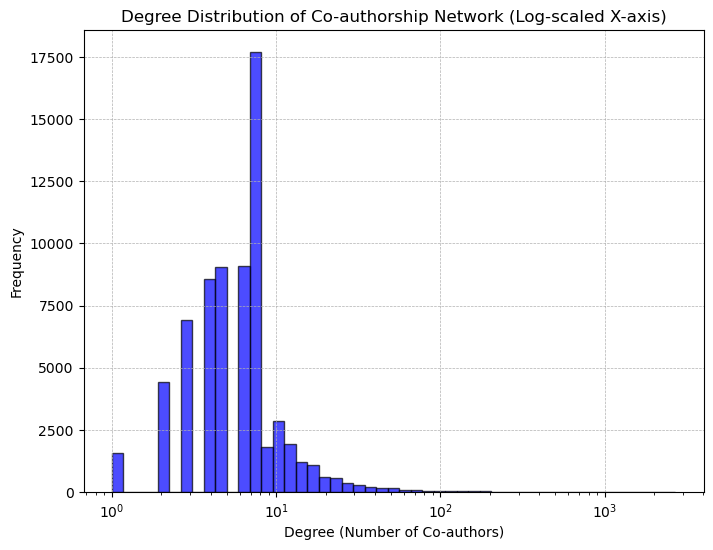

In [ ]:
import matplotlib.pyplot as plt

degrees = [d for _, d in G.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=np.logspace(np.log10(min(degrees)+1), np.log10(max(degrees)), 50), 
         color='blue', edgecolor='black', alpha=0.7)

plt.xscale("log")
plt.xlabel("Degree (Number of Co-authors)")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Co-authorship Network (Log-scaled X-axis)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()